<a href="https://colab.research.google.com/github/shubham6907/Python-Codes/blob/main/Split_of_nested_PDF_and_merge_by_group.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Script Execution Instructions:**
1. **create root folder:** File extractor
2. **create sub folders inside root folder:** All-extracted-pdf, Extracted-pdf, Merged-pdf
3. **create 3 python scripts with .py extention inside root folder:** split-pdf.py, copy-input-files.py, merge-pdf.py
4. **place original_file.pdf (original PDF file with attachments) inside root folder**
5. **set all the path and file name variables in all 3 scripts with correct values**
6. **open cmd or terminal and change current working directory to root folder (cd 'File extractor')**
7. **execute python scripts in sequence by executing below commands in cmd or terminal:** python split-pdf.py **->** python copy-input-files.py
8. **update 'AllNestedFiles.xlsx' file with grouping logic**
9. **execute python script by executing below command in cmd or terminal:** python merge-pdf.py
8. **do these validation checks to ensure successful execution:** All the attachments from original PDF are present in 'Extracted-pdf' folder with the exact hirerachy with sub folders **->** 'AllNestedFiles.xlsx' file is present in 'File extractor' folder and contains all the expected information **->** all the attachments from 'Extracted-pdf' folder and its sub folders are present in 'All-extracted-pdf' folder **->** all the merged pdf files are present in 'Merged-pdf' folder based on defined grouping logic in 'AllNestedFiles.xlsx'.



## **Splitting Nested PDF (Extracting attachments from PDF with attachments)**

**split-pdf.py:** extract attachments from original pdf with exact hirerachy in pdf tree represented by sub folders inside Extracted-pdf folder

In [ ]:
import PyPDF2
import logging
from pathlib import Path
import pandas as pd
import openpyxl

logging.basicConfig(
    level=logging.DEBUG,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.StreamHandler(),
        logging.FileHandler('split-pdf.log')
    ]
)

final_df = pd.DataFrame()

def getAttachments(reader):
    """
    Retrieves the file attachments of the PDF as a dictionary of file names
    and the file data as a bytestring.

    :return: dictionary of filenames and bytestrings
    """
    try:
        attachments = {}
        #First, get those that are pdf attachments
        catalog = reader.trailer["/Root"]

        try:
            # logging.info(f"line 28: {catalog}")
            # logging.info(f"line 29: {catalog['/Metadata']}")
            # logging.info(f"line 30: {catalog['/Names']}")
            # logging.info(f"line 31: {catalog['/Names']['/EmbeddedFiles']}")
            # logging.info(f"line 32: {catalog['/Names']['/EmbeddedFiles']['/Kids']}")
            # logging.info(f"line 33: {catalog['/Names']['/EmbeddedFiles']['/Kids'][0].get_object()['/Names']}")

            if "/Names" in catalog["/Names"]['/EmbeddedFiles']:
                fileNames = catalog['/Names']['/EmbeddedFiles']['/Names']
                for f in fileNames:
                    if isinstance(f, str):
                        name = f
                        dataIndex = fileNames.index(f) + 1
                        fDict = fileNames[dataIndex].get_object()
                        fData = fDict['/EF']['/F'].get_data()
                        attachments[name] = fData

            elif "/Kids" in catalog["/Names"]['/EmbeddedFiles']:
                for kid in catalog['/Names']['/EmbeddedFiles']['/Kids']:
                    fileNames = kid.get_object()['/Names']
                    for f in fileNames:
                        if isinstance(f, str):
                            name = f
                            dataIndex = fileNames.index(f) + 1
                            fDict = fileNames[dataIndex].get_object()
                            fData = fDict['/EF']['/F'].get_data()
                            attachments[name] = fData

        except Exception as e:
            logging.exception(e)

        for page_object in reader.pages:
            if "/Annots" in page_object:
                for annot in page_object['/Annots']:
                    annotobj = annot.get_object()
                    if annotobj['/Subtype'] == '/FileAttachment':
                        fileobj = annotobj["/FS"]
                        attachments[fileobj["/F"]] = fileobj["/EF"]["/F"].get_data()
        return attachments

    except Exception as e:
        logging.exception("No further attachments found.")
        return {}

def extract_pdfs(filename, output_folder):
    global final_df
    folder_paths_list = []
    counter = 0
    handler = open(filename, 'rb')
    reader = PyPDF2.PdfReader(handler)
    dictionary = getAttachments(reader)
    if dictionary != {}:
        logging.info("{} attachments found in file {}".format(len(dictionary),filename))
        for fName, fData in dictionary.items():
            counter = counter + 1
            folder_name = (fName.split('.')[0:-1])
            folder_name = '.'.join(folder_name).strip()
            folder_name = (folder_name.split('(')[0])
            folder_name = ''.join(folder_name).strip()
            file_ext = (fName.split('.')[-1]).strip()

            file_name = folder_name+'.'+file_ext
            filename_new = (filename.split('\\')[-1])
            new_row = {'input_filename': [file_name,], 'output_filename': [filename_new,], 'sequence': [counter,]}
            new_df = pd.DataFrame(new_row)
            final_df = pd.concat([final_df, new_df]).sort_index(ignore_index=True)

            if(file_ext.lower() != 'pdf'):
                logging.error(f"Nested file {fName} is not in PDF format.")
            folder_path = output_folder+folder_name
            logging.info("folder path: {}".format(folder_path))
            folder_paths_list.append(folder_path)
            Path(folder_path).mkdir(parents=True, exist_ok=True)
            attachment_path = f"{folder_path}/{folder_name}.{file_ext}"
            logging.info("attachment path: {}".format(attachment_path))
            try:
                with open(attachment_path, 'wb') as outfile:
                    outfile.write(fData)
            except Exception as e:
                logging.exception("Error in extract pdfs: {}".format(e))
    return folder_paths_list



#------------------ Original File (1st Split) -------------------------
filename = 'original_file.pdf'
path = 'C:\\Users\\shubham\\Downloads\\File extractor\\Extracted-pdf\\'
folder_paths_list = []
folder_paths_list = extract_pdfs(filename, path)
filename_list = []

#------------------ Further Split of Files -----------------------
Nested_hirarchy = []

def split_extracted(folder_paths_list):
    if folder_paths_list != []:
        for path in folder_paths_list:
            path = path.strip()
            logging.info("input path: {}".format(path))
            filename_list = path.split('\\')
            filename = filename_list[len(filename_list)-1]
            filename = filename + '.pdf'
            path = path + '\\'
            filename = path + filename
            logging.info("filename: {}".format(filename))
            folder_paths_list_temp = extract_pdfs(filename, path)
            Nested_hirarchy.append(folder_paths_list_temp)
    else:
        logging.info("No further attachments found.")


split_extracted(folder_paths_list)

if Nested_hirarchy != []:
    for l in Nested_hirarchy:
        split_extracted(l)
        Nested_hirarchy.remove(l)


print(final_df)
excel_file_path = 'AllNestedFiles.xlsx'
# Export the DataFrame to Excel
final_df.to_excel(excel_file_path, index=False)
print(f'DataFrame exported to {excel_file_path}')


## **Copying all the files from root folder and its sub folders to specific destination folder**

**copy-input-files.py:** copy attachments from Extracted-pdf folder and its sub folders to specific destination folder All-extracted-pdf

In [ ]:
import os
import shutil

def copy_files_from_folders(root_folder, output_folder):
    # Create the output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Walk through the root folder and copy files
    for foldername, subfolders, filenames in os.walk(root_folder):
        for filename in filenames:
            source_path = os.path.join(foldername, filename)
            destination_path = os.path.join(output_folder, filename)

            # Handle file name conflicts if necessary
            # if os.path.exists(destination_path):
            #     base, extension = os.path.splitext(filename)
            #     destination_path = os.path.join(output_folder, f"{base}_duplicate{extension}")

            # Copy the file
            shutil.copy2(source_path, destination_path)
            print(f"Copied: {filename} from {foldername} to {output_folder}")

# Example usage
root_folder = 'C:\\Users\\shubham\\Downloads\\File extractor\\Extracted-pdf\\'
output_folder = 'C:\\Users\\shubham\\Downloads\\File extractor\\All-extracted-pdf\\'
copy_files_from_folders(root_folder, output_folder)

## **Merge all the PDFs from given input folder based on logic defined in '*AllNestedFiles.xlsx*' file**

### Format of '*AllNestedFiles.xlsx*' file:

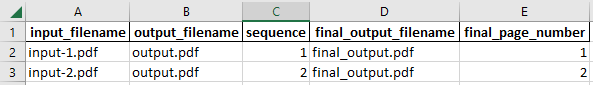

**merge-pdf.py:** merge all the pdfs from All-extracted-pdf folder based on grouping logic defined in 'AllNestedFiles.xlsx' and place generated merged pdfs in Merged-pdf folder

In [ ]:
import PyPDF2
import pandas as pd
import logging

logging.basicConfig(
    level=logging.DEBUG,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.StreamHandler(),
        logging.FileHandler('merge-pdf.log')
    ]
)

def merge_pdfs(pdf_list, output_path):
    if len(pdf_list) > 1:
        merger = PyPDF2.PdfMerger()

        for pdf in pdf_list:
            merger.append(pdf)

        with open(output_path, 'wb') as output_file:
            merger.write(output_file)
    elif len(pdf_list) == 1:
        logging.info("Merge skiped due to single input pdf.")
    else:
        logging.info("Merge skiped due to no input pdf.")

input_path = 'C:\\Users\\shubham\\Downloads\\File extractor\\All-extracted-pdf\\'
output_path = 'C:\\Users\\shubham\\Downloads\\File extractor\\Merged-pdf\\'
original_pdf_file = "original_file.pdf"
AllNestedFiles_filename = 'AllNestedFiles.xlsx'
df = pd.read_excel(AllNestedFiles_filename)
# print(df)
# print(df.columns)

groups = df['output_filename'].unique()

for group in groups:
    if group == original_pdf_file:
        continue
    temp_df = df[(df['output_filename'] == group)]
    sorted_df = temp_df.sort_values(by='sequence')
    # temp_df = temp_df.sort_values(by='sequence', inplace=True)
    pdf_list = []
    output_file_name = ''
    max_value_sequence = sorted_df['sequence'].max()
    for index, row in sorted_df.iterrows():
        start_page = 1

        if row['sequence'] == max_value_sequence:
            pdf_list.append(row['input_filename'])
            for i in range(0,len(pdf_list)):
                pdf_list[i] = input_path + pdf_list[i]
            output_file_name = row['final_output_filename']
            output_file_path = output_path + output_file_name
            merge_pdfs(pdf_list, output_file_path)
            logging.info("Merge completed successfully for all the files in the current group.")
            sorted_df = pd.DataFrame()
            break

        if row['final_page_number'] == start_page and pdf_list != []:
            for i in range(0,len(pdf_list)):
                pdf_list[i] = input_path + pdf_list[i]
            merge_pdfs(pdf_list, output_file_path)
            pdf_list = []
            output_file_name = ''

        pdf_list.append(row['input_filename'])
        output_file_name = row['final_output_filename']
        output_file_path = output_path + output_file_name

        # print(f"Index: {index}, input_filename: {row['input_filename']}, output_filename: {row['output_filename']}, final_output_filename: {row['final_output_filename']}, final_page_number: {row['final_page_number']}")

logging.info("Merge completed successfully for all the nested files.")